In [5]:
!pip install gradio scikit-learn imbalanced-learn pandas numpy matplotlib seaborn --quiet

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, RocCurveDisplay)
import gradio as gr
import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported successfully!")

 Libraries imported successfully!


In [49]:
try:
    df = pd.read_csv('diabetes_prediction_dataset.csv') 
    print(" Data loaded successfully!")
    print("\nDataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print("\nData Types:")
    print(df.dtypes)
 
    print("\nTarget Variable Distribution:")
    print(df['diabetes'].value_counts(normalize=True))
    
    # Display sample
    print("\nData Sample:")
    display(df.head(3))
    
except Exception as e:
    print(f"Error loading data: {e}")

 Data loaded successfully!

Dataset Overview:
Shape: (100000, 9)

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

Data Types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Target Variable Distribution:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

Data Sample:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0


In [51]:

def preprocess_data(df):
    if df.isnull().sum().any():
        print("\nHandling missing values...")
        for col in df.columns:
            if df[col].isnull().any():
                if df[col].dtype in ['float64', 'int64']:
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mode()[0], inplace=True)
 
    df['gender'] = df['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})

    smoking_map = {
        'never': 0,
        'former': 1,
        'current': 2,
        'not current': 1,
        'ever': 1
    }
    df['smoking_history'] = df['smoking_history'].map(smoking_map)
    return df
try:
    df_clean = preprocess_data(df.copy())
    print("\nData cleaning completed!")
    print("\nCleaned Data Sample:")
    display(df_clean.head(3))
except Exception as e:
    print(f"Error in preprocessing: {e}")


Data cleaning completed!

Cleaned Data Sample:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,0.0,25.19,6.6,140,0
1,0,54.0,0,0,NaN,27.32,6.6,80,0
2,1,28.0,0,0,0.0,27.32,5.7,158,0


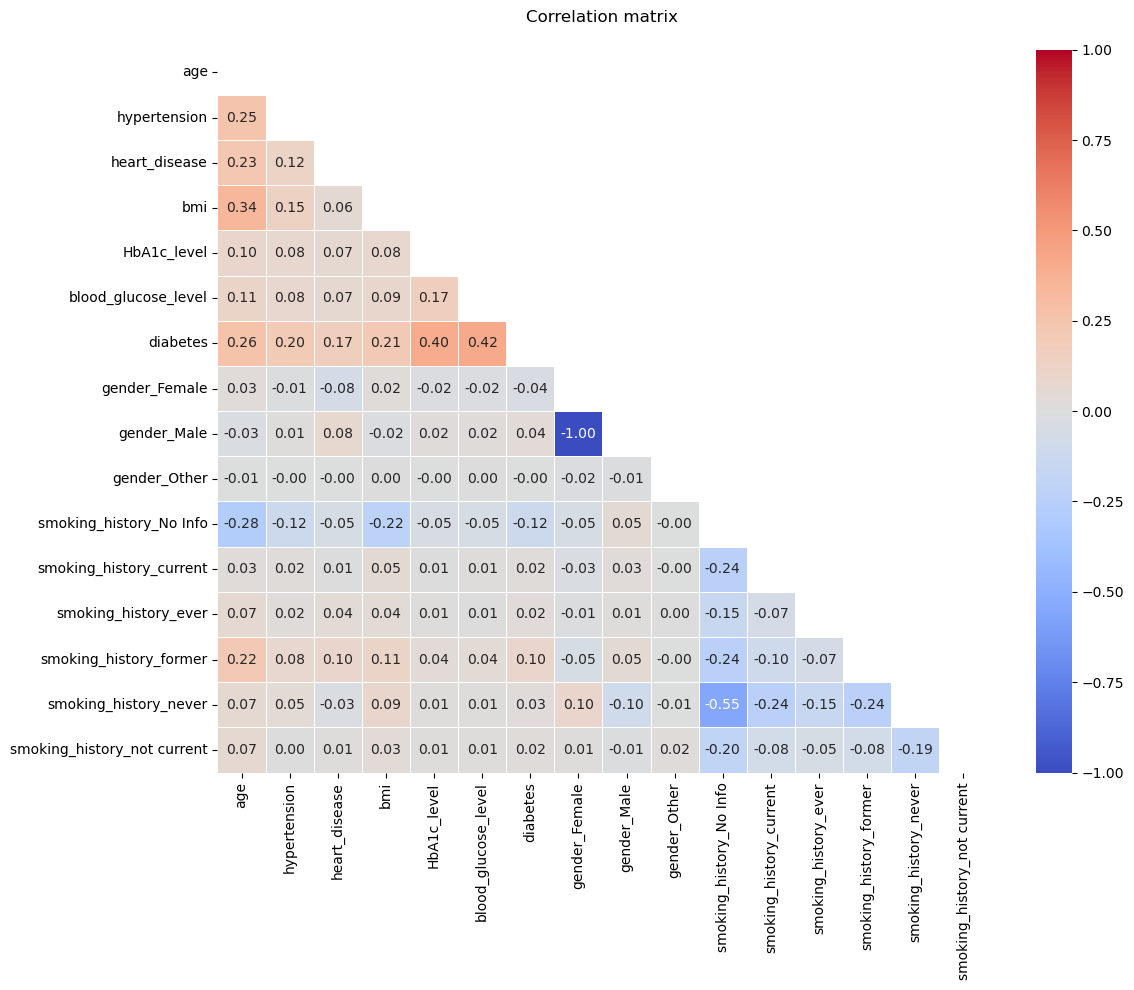

In [23]:
plt.figure(figsize=(12, 10))
corr = df_processed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, linewidths=.5)
plt.title('Correlation matrix', pad=20)
plt.tight_layout()
plt.show()


Performing EDA...


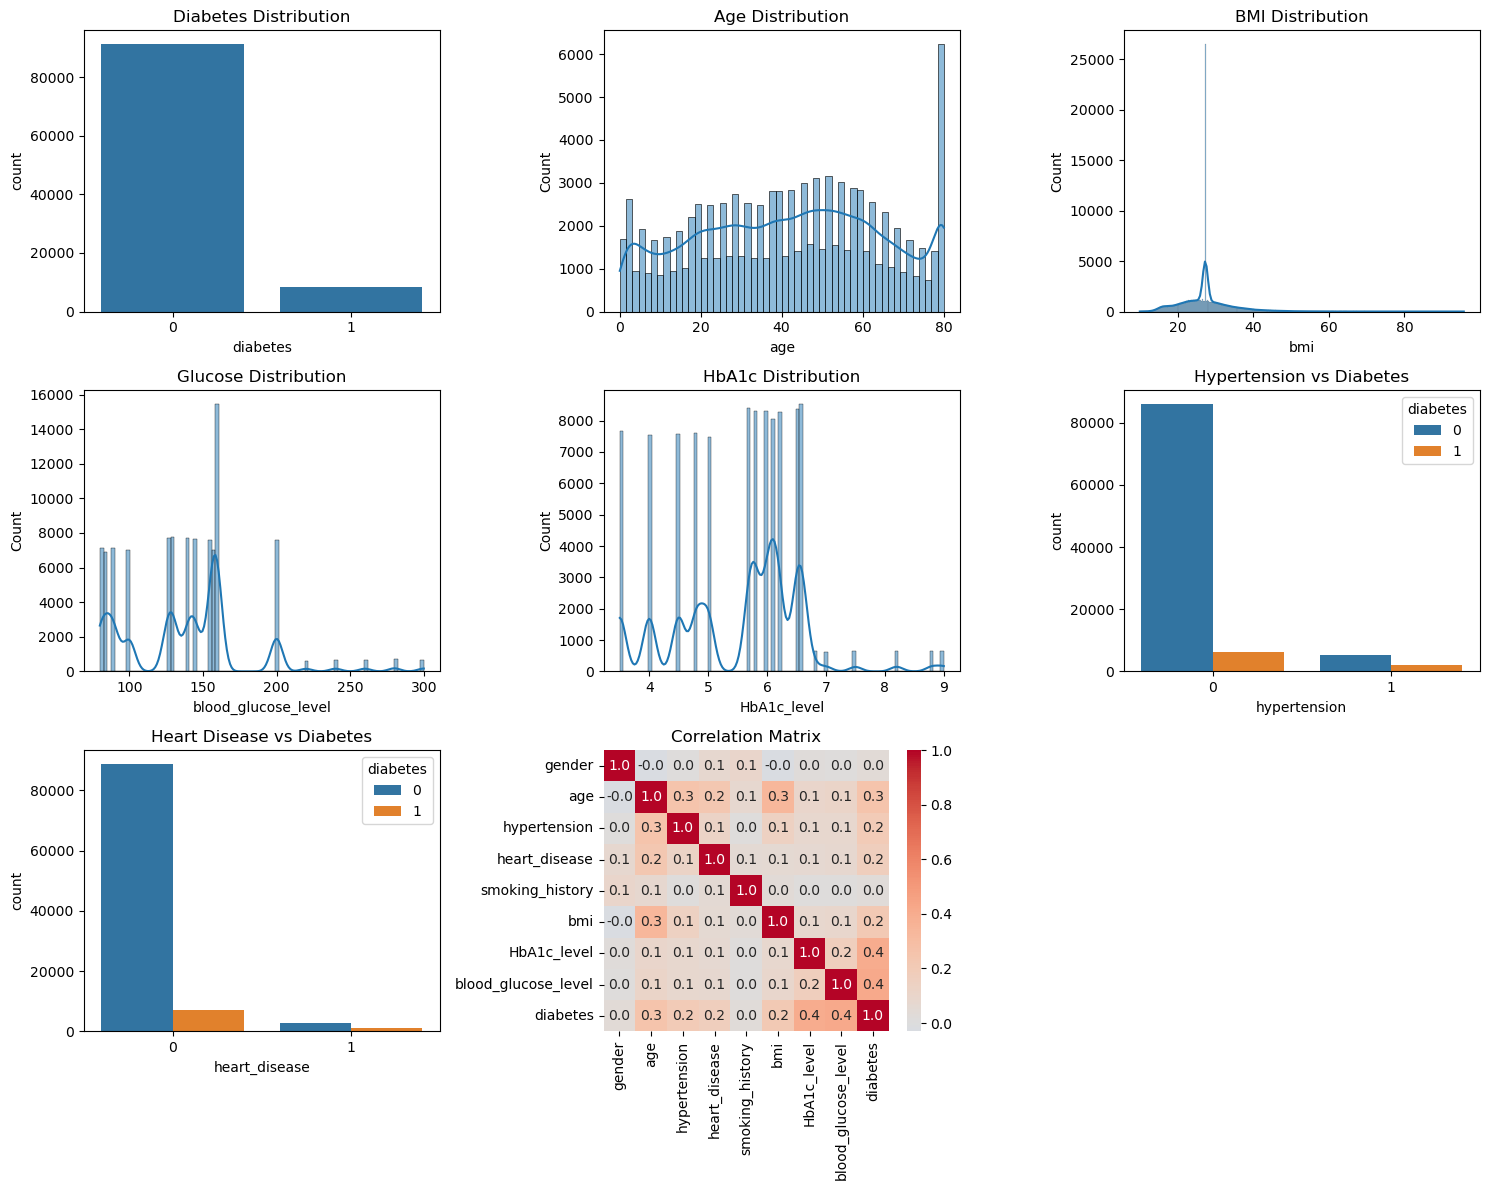

In [53]:
#
def perform_eda(df):
    plt.figure(figsize=(15, 12))
  
    plt.subplot(3, 3, 1)
    sns.countplot(x='diabetes', data=df)
    plt.title('Diabetes Distribution')
    
    plt.subplot(3, 3, 2)
    sns.histplot(df['age'], kde=True)
    plt.title('Age Distribution')
  
    plt.subplot(3, 3, 3)
    sns.histplot(df['bmi'], kde=True)
    plt.title('BMI Distribution')
  
    plt.subplot(3, 3, 4)
    sns.histplot(df['blood_glucose_level'], kde=True)
    plt.title('Glucose Distribution')
  
    plt.subplot(3, 3, 5)
    sns.histplot(df['HbA1c_level'], kde=True)
    plt.title('HbA1c Distribution')
    
    plt.subplot(3, 3, 6)
    sns.countplot(x='hypertension', hue='diabetes', data=df)
    plt.title('Hypertension vs Diabetes')

    plt.subplot(3, 3, 7)
    sns.countplot(x='heart_disease', hue='diabetes', data=df)
    plt.title('Heart Disease vs Diabetes')
   
    plt.subplot(3, 3, 8)
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

print("\nPerforming EDA...")
perform_eda(df_clean)

In [55]:

print("\nFeature Engineering...")

df_clean['age_group'] = pd.cut(df_clean['age'],
                              bins=[0, 30, 45, 60, 100],
                              labels=['<30', '30-45', '45-60', '60+'])

df_clean['bmi_category'] = pd.cut(df_clean['bmi'],
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=['Under', 'Normal', 'Over', 'Obese'])

df_final = pd.get_dummies(df_clean, columns=['age_group', 'bmi_category'], drop_first=True)

print("\nEngineered Features Sample:")
display(df_final.head(2))


Feature Engineering...

Engineered Features Sample:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group_30-45,age_group_45-60,age_group_60+,bmi_category_Normal,bmi_category_Over,bmi_category_Obese
0,0,80.0,0,1,0.0,25.19,6.6,140,0,False,False,True,False,True,False
1,0,54.0,0,0,NaN,27.32,6.6,80,0,False,True,False,False,True,False


In [57]:

X = df_final.drop('diabetes', axis=1)
y = df_final['diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData Prepared for Modeling:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Testing set: {X_test_scaled.shape}")


Data Prepared for Modeling:
Training set: (80000, 14)
Testing set: (20000, 14)



Training Random Forest Model...

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     18300
           1       0.47      0.91      0.62      1700

    accuracy                           0.91     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.91      0.92     20000

ROC AUC Score: 0.98


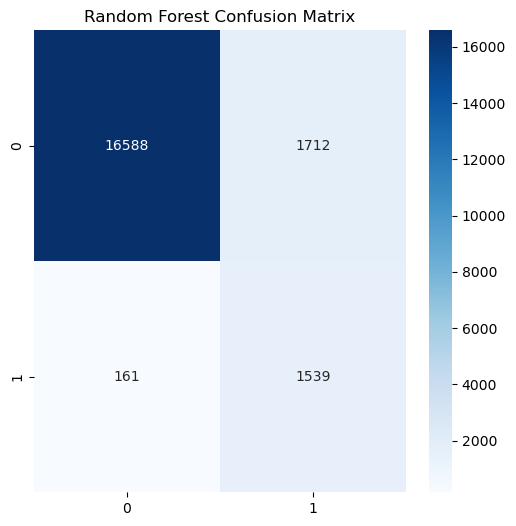

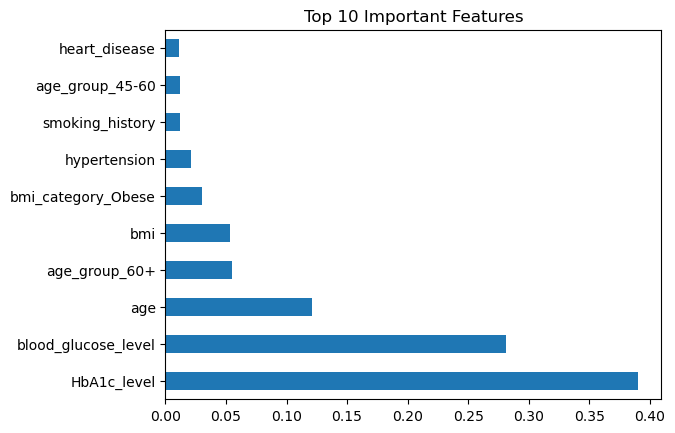

In [108]:

print("\nTraining Random Forest Model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_rf):.2f}")

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

In [112]:

def clinical_interpretation(prediction):
    interpretations = {
        "Diabetic-High": ("Urgent medical intervention required. High probability of Type 2 Diabetes.",
                         "Refer to endocrinologist immediately."),
        "Diabetic-Medium": ("Probable diabetes diagnosis.",
                          "Lifestyle changes and medication recommended."),
        "Non-Diabetic-Medium": ("Pre-diabetic range.",
                               "Regular monitoring and preventive measures advised."),
        "Non-Diabetic-Low": ("Normal glucose metabolism.",
                            "Maintain healthy lifestyle.")
    }
    key = f"{prediction['Prediction']}-{prediction['Risk Level']}"
    return interpretations.get(key, ("Consult healthcare provider.", "Further evaluation needed."))

model_performance = {
    "Model": "Random Forest",
    "Accuracy": f"{accuracy_score(y_test, y_pred_rf):.2%}",
    "Precision": f"{precision_score(y_test, y_pred_rf):.2%}",
    "Recall": f"{recall_score(y_test, y_pred_rf):.2%}",
    "F1-Score": f"{f1_score(y_test, y_pred_rf):.2%}",
    "ROC AUC": f"{roc_auc_score(y_test, y_prob_rf):.2%}"
}

conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
conf_matrix_plot = plt.gcf()
plt.close()

with gr.Blocks(title="Diabetes Prediction System") as demo:
    with gr.Row():
        gr.Markdown("# Diabetes Risk Prediction System")
    
    with gr.Tab("Patient Assessment"):
        with gr.Row():
            with gr.Column():
                gender = gr.Dropdown(["Female", "Male"], label="Gender")
                age = gr.Slider(0, 100, value=45, label="Age (years)")
                hypertension = gr.Checkbox(label="Hypertension")
                heart_disease = gr.Checkbox(label="Heart Disease")
            
            with gr.Column():
                smoking_history = gr.Dropdown(["never", "former", "current"], label="Smoking History")
                bmi = gr.Slider(10, 50, value=25, label="BMI")
                hba1c = gr.Slider(3, 15, value=5.5, label="HbA1c Level (%)")
                glucose = gr.Slider(70, 300, value=100, label="Blood Glucose (mg/dL)")
        
        with gr.Row():
            submit_btn = gr.Button("Assess Diabetes Risk", variant="primary")
            clear_btn = gr.Button("Clear All")
        
        with gr.Row():
            with gr.Column():
                results_json = gr.JSON(label="Prediction Results")
            with gr.Column():
                clinical_dx = gr.Textbox(label="Clinical Interpretation")
                recommendation = gr.Textbox(label="Medical Recommendation")
    
    with gr.Tab("Model Insights"):
        with gr.Row():
            with gr.Column():
                gr.Markdown("### Model Performance Summary")
                gr.JSON(value=model_performance)
                
                gr.Markdown("### Confusion Matrix")
                gr.Plot(value=conf_matrix_plot)
            
            with gr.Column():
                gr.Markdown("### Feature Importance")
                gr.DataFrame(value=feature_importance.sort_values('Importance', ascending=False).head(10))
        
        with gr.Row():
            gr.Markdown("### Model Evaluation Visualizations")
            gr.Plot(value=roc_plt)
            gr.Plot(value=pr_plt)
    submit_btn.click(
        fn=predict_diabetes,
        inputs=[gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c, glucose],
        outputs=[results_json]
    ).then(
        fn=lambda res: clinical_interpretation(res),
        inputs=[results_json],
        outputs=[clinical_dx, recommendation]
    )
    clear_btn.click(
        fn=lambda: [None, None, 45, False, False, "never", 25, 5.5, 100, None, None, None],
        outputs=[results_json, clinical_dx, recommendation, gender, age, hypertension, 
                heart_disease, smoking_history, bmi, hba1c, glucose]
    )

print("\nLaunching Enhanced Diabetes Prediction Interface...")
demo.launch()


Launching Enhanced Diabetes Prediction Interface...
* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
